In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *     # Import all the preprocessing methods
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, balanced_accuracy_score, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np
import sys, pickle, itertools
from sklearn.model_selection import train_test_split, TimeSeriesSplit
plt.rcParams["figure.figsize"] = (10,7)

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
train_set = pd.read_csv('../data/train_df_expanded_KNN_imp_7kfeats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

In [14]:
y_train = train_set['Target > 2']
x_train = train_set.drop(['Date', 'window_start', 'window_duration', 'within_window', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

X_test = X_test.iloc[26:]
y_test = y_test.iloc[26:]

In [6]:
# X_test = X_test.drop(['Abs Target'], axis=1)

# df_temp = pd.concat([X_train, y_train], axis=1)
# df_temp['Target > 2'] = df_temp['Abs Target'].apply(lambda x: 1 if x > 1.95 else 0)
# y_train = df_temp['Target > 2']
# X_train = df_temp.drop(['Target > 2', 'Abs Target'], axis=1)

In [7]:
# # Apply label smoothing to the target variable
# def smooth_labels(y, alpha=0.1):
#     return y * (1 - alpha) + alpha * 0.5
# y_train_smoothed = smooth_labels(y_train, alpha=0.3)

In [16]:
#Keep best X features
with open("../metadata/top_K_feat_from_7k.pkl", "rb") as f:
    top_k_feats = pickle.load(f)

x_train = x_train[list(top_k_feats)]

In [17]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_test, y_test)

In [18]:
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'eval_metric': ['logloss'],
    'tree_method': ['exact'],
    'nthread': [-2],
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, np.sqrt(sum(y_train==0)/sum(y_train==1))]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [19]:
def find_optimal_threshold(y_true, y_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    
    # Calculate the distance from each point on the ROC curve to the top-left corner
    distances = np.sqrt(np.square(1 - tpr) + np.square(fpr))
    
    # Find the index of the smallest distance
    min_distance_index = np.argmin(distances)
    
    # Return the threshold corresponding to the smallest distance
    return thresholds[min_distance_index]

In [20]:
# Initialize empty lists to store results
auc_scores = []
aucpr_scores = []
best_thresholds = []
confusion_matrices = []
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    clf = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=250,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = clf.predict(dtrain)
    y_pred_val = clf.predict(dval)

    num_trees = clf.best_ntree_limit
    num_trees_list.append(num_trees)

    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_val)
    
    # Calculate AUC and AUCPR
    print(f'AUC={auc(recall, precision)}')
    print(f'AUCPR={average_precision_score(y_test, y_pred_val)}')
    auc_scores.append(auc(recall, precision))
    aucpr_scores.append(average_precision_score(y_test, y_pred_val))

    # Find the best threshold
    best_threshold = find_optimal_threshold(y_test, y_pred_val)
    best_thresholds.append(best_threshold)

    # Calculate TP, FP, FN using the best threshold
    y_pred = (y_pred_val > best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    confusion_matrices.append((tp, fp, fn))
    print(f'TP={tp}, FP={fp}, FN={fn}')

    print('--'*5)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'AUC': auc_scores[i],
        'AUCPR': aucpr_scores[i],
        'Best_threshold': best_thresholds[i],
        'TP': confusion_matrices[i][0],
        'FP': confusion_matrices[i][1],
        'FN': confusion_matrices[i][2],
    })

AUC=0.953962688493762
AUCPR=0.9540991955036271
TP=184, FP=83, FN=4
----------
AUC=0.9542033737089577
AUCPR=0.9543734870677545
TP=184, FP=72, FN=4
----------
AUC=0.9569790208005289
AUCPR=0.9572670931857723
TP=184, FP=49, FN=4
----------
AUC=0.9595734509185839
AUCPR=0.959685444098699
TP=184, FP=62, FN=4
----------
AUC=0.9589295099890923
AUCPR=0.9590653017827052
TP=186, FP=100, FN=2
----------
AUC=0.9365607253409629
AUCPR=0.9369282491916979
TP=184, FP=143, FN=4
----------
AUC=0.9637382833165254
AUCPR=0.9638596288386974
TP=185, FP=73, FN=3
----------


KeyboardInterrupt: 

In [23]:
np.argmax([x['AUCPR'] for x in results])

11

In [26]:
num_trees_list[11]

43

In [25]:
results[26]

{'hyperparameters': {'alpha': 1,
  'lambda': 5,
  'colsample_bytree': 1,
  'colsample_bylevel': 0.7,
  'subsample': 1,
  'eval_metric': 'logloss',
  'tree_method': 'exact',
  'nthread': -2,
  'objective': 'binary:logistic',
  'scale_pos_weight': 1},
 'AUC': 0.972685676226667,
 'AUCPR': 0.972769247720651,
 'Best_threshold': 0.49884367,
 'TP': 173,
 'FP': 10,
 'FN': 15}

### Get best result

In [13]:
y_pred_train = clf.predict(dtrain)
y_pred_val = clf.predict(dval)

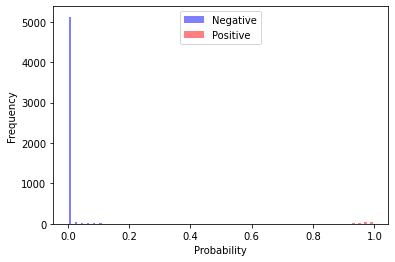

In [14]:
# plot the histogram of probabilities with the color representing the true label
plt.hist([y_pred_val[y_test==0], y_pred_val[y_test==1]], bins=50, color=['b', 'r'], alpha=0.5, label=['Negative', 'Positive'])
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper center')
plt.show()

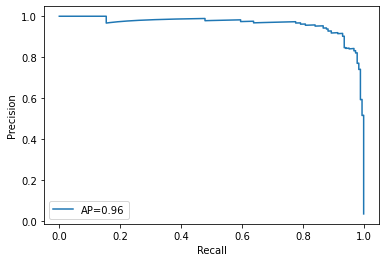

In [15]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_val)
average_precision = average_precision_score(y_test, y_pred_val)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [16]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_val)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.3725


## Old confusion-matrix
All feat:
TP=269
FN=38
FP=23

Top 4 feat:
TP=273
FN=34
FP=23

In [18]:
# predict binary labels using the best threshold
y_pred = (y_pred_val >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [19]:
cm

array([[5258,   16],
       [  13,  175]], dtype=int64)

In [40]:
cm

array([[8722,   33],
       [  34,  273]], dtype=int64)